# OLS regressions - baseline for Capstone analysis - Casual
In this notebook, I perform OLS regressions using *casual* DC to DC CaBi trips as the dependent variable.

Work in progress - residuals are wonky. Lots of heteroskedasticity and non-normality.

In [2]:
from util_functions import *
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid')
import statsmodels.graphics.gofplots as gofplots
%matplotlib inline

set_env_path()
conn, cur = aws_connect()
query = """
SELECT *,
CASE day_of_week WHEN 5 THEN 1 WHEN 6 THEN 1 ELSE 0 END AS weekend_dummy
from final_db
"""
df = pd.read_sql(query, con=conn)
df.shape

(2750, 834)

### First specification attempt - theory based

In [3]:
def fitOLS(equation, cov='nonrobust'):
    '''
    This function uses statsmodels.ols to estimate OLS regressions using R/patsy-style syntax.
    
    Args:
        equation (str): A patsy-style regression equation.
                        e.g. 'cabi_trips ~ apparenttemperaturehigh + daylight_hours + rain'
        cov      (str): A specific covariance matrix type. Default is 'nonrobust'. 
                        HC0-HC3 available for heteroskedasticity-robust standard errors.
    Returns:
        results: A RegressionResults object which summarizes the fit of a linear regression model.
    '''
    model = smf.ols('{}'.format(equation), df)
    results = model.fit(cov_type='{}'.format(cov), use_t=True)
    return results

We know that a lot of trips depend on weather, but we should be careful to avoid multicollinearity. X below contains all of the variables in question.

In [7]:
df.head().transpose()

,0,1,2,3,4
date,2010-09-20,2010-09-21,2010-09-22,2010-09-23,2010-09-24
year,2010,2010,2010,2010,2010
quarter,3,3,3,3,3
month,9,9,9,9,9
day_of_week,1,2,3,4,5
apparenttemperaturehightime,17,17,17,16,16
apparenttemperaturelowtime,7,7,6,7,7
temperaturehightime,17,17,17,15,16
temperaturelowtime,7,7,6,7,7
precipintensitymaxtime,19,19,22,19,19


In [9]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
X = df[['cabi_trips_wdc_to_wdc_casual', 'cabi_trips_casual',
        'cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_member',
        'cabi_trip_dur_avg_casual', 'cabi_trip_dur_avg_member',
        'cabi_trip_dist_avg_casual', 'cabi_trip_dist_avg_member',
        'cabi_bikes_avail', 'cabi_stations_wdc', 'cabi_docks_wdc',
        'cabi_dur_empty_wdc', 'cabi_dur_full_wdc', 'cabi_util_rate',
        'cabi_active_members_monthly', 'dless_trips_all', 'dless_tripdist_avg_all',
        'date', 'dc_pop', 'quarter', 'month', 'daylight_hours', 
        'apparenttemperaturehigh', 'apparenttemperaturelow',
        'apparenttemperaturehightime', 'cloudcover', 'humidity',
        'rain', 'snow', 'nats_single', 'nats_double', 
        'us_holiday', 'dc_bike_event', 'day_of_week']]
X.describe().round(0).transpose()

,count,mean,std,min,25%,50%,75%,max
cabi_trips_wdc_to_wdc_casual,2750.0,1382.0,1327.0,0.0,390.0,984.0,1950.0,9130.0
cabi_trips_casual,2750.0,1552.0,1519.0,0.0,424.0,1083.0,2192.0,10173.0
cabi_trips_wdc_to_wdc,2750.0,6341.0,3174.0,0.0,3882.0,6190.0,9041.0,14964.0
cabi_trips_wdc_to_wdc_member,2750.0,4959.0,2317.0,0.0,3252.0,4982.0,6755.0,9979.0
cabi_trip_dur_avg_casual,2750.0,2246.0,495.0,0.0,1983.0,2257.0,2515.0,7085.0
cabi_trip_dur_avg_member,2750.0,714.0,86.0,0.0,662.0,708.0,756.0,1272.0
cabi_trip_dist_avg_casual,2750.0,1748.0,149.0,0.0,1679.0,1748.0,1824.0,2863.0
cabi_trip_dist_avg_member,2750.0,1774.0,124.0,0.0,1720.0,1796.0,1849.0,2238.0
cabi_bikes_avail,2750.0,2841.0,1255.0,97.0,1658.0,3115.0,3900.0,4612.0
cabi_stations_wdc,2750.0,181.0,54.0,32.0,140.0,192.0,218.0,268.0


In [11]:
print(X.corr().round(3))

                              cabi_trips_wdc_to_wdc_casual  cabi_trips_casual  \
cabi_trips_wdc_to_wdc_casual                         1.000              0.999   
cabi_trips_casual                                    0.999              1.000   
cabi_trips_wdc_to_wdc                                0.768              0.768   
cabi_trips_wdc_to_wdc_member                         0.479              0.480   
cabi_trip_dur_avg_casual                             0.362              0.357   
cabi_trip_dur_avg_member                             0.546              0.546   
cabi_trip_dist_avg_casual                            0.148              0.154   
cabi_trip_dist_avg_member                            0.286              0.284   
cabi_bikes_avail                                     0.410              0.417   
cabi_stations_wdc                                    0.385              0.391   
cabi_docks_wdc                                       0.385              0.392   
cabi_dur_empty_wdc          

From here, we can pare down the variables further.
We are mainly interested in cabi_trips_wdc_to_wdc_casual, so we can drop a lot of CaBi variables that are highly correlated with our dependent variable.
Also, we can look at other X variables we want to include and drop things that are highly correlated with them, for example: we want to use dc_pop but it's highly correlated with cabi_bikes_avail, cabi_stations_wdc, and cabi_docks_wdc, as they all increase over time. 

In [12]:
#corr = X.corr()
#sns.heatmap(corr)
X0 = X[['cabi_trips_wdc_to_wdc_casual',
        'cabi_util_rate', 'cabi_active_members_monthly', 'dless_trips_all',
        'dc_pop', 'daylight_hours', 'apparenttemperaturehigh', 'cloudcover']]
print(X0.corr().round(3))

                              cabi_trips_wdc_to_wdc_casual  cabi_util_rate  \
cabi_trips_wdc_to_wdc_casual                         1.000           0.419   
cabi_util_rate                                       0.419           1.000   
cabi_active_members_monthly                          0.579           0.515   
dless_trips_all                                      0.019          -0.123   
dc_pop                                               0.386          -0.260   
daylight_hours                                       0.505           0.598   
apparenttemperaturehigh                              0.535           0.696   
cloudcover                                          -0.322          -0.158   

                              cabi_active_members_monthly  dless_trips_all  \
cabi_trips_wdc_to_wdc_casual                        0.579            0.019   
cabi_util_rate                                      0.515           -0.123   
cabi_active_members_monthly                         1.000      

Next I drop some correlated X variables and run the regression.

In [18]:
results = fitOLS('cabi_trips_wdc_to_wdc_casual ~ cabi_util_rate + \
                cabi_active_members_monthly + dc_pop + quarter + \
                apparenttemperaturehigh + snow + rain + cloudcover + C(day_of_week) + \
                nats_single + nats_double + us_holiday + dless_trips_all', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     cabi_trips_wdc_to_wdc_casual   R-squared:                       0.700
Model:                                      OLS   Adj. R-squared:                  0.698
Method:                           Least Squares   F-statistic:                     210.3
Date:                          Tue, 15 May 2018   Prob (F-statistic):               0.00
Time:                                  18:14:57   Log-Likelihood:                -22018.
No. Observations:                          2750   AIC:                         4.407e+04
Df Residuals:                              2731   BIC:                         4.419e+04
Df Model:                                    18                                         
Covariance Type:                            HC0                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1.446e+04    682.537    -21.186      0.000   -1.58e+04   -1.31e+04
C(day_of_week)[T.1.0]       -1079.7307     59.080    -18.276      0.000   -1195.577    -963.884
C(day_of_week)[T.2.0]       -1242.5010     58.797    -21.132      0.000   -1357.793   -1127.209
C(day_of_week)[T.3.0]       -1265.7830     58.719    -21.557      0.000   -1380.921   -1150.645
C(day_of_week)[T.4.0]       -1227.6021     58.281    -21.064      0.000   -1341.881   -1113.323
C(day_of_week)[T.5.0]        -936.5270     59.530    -15.732      0.000   -1053.256    -819.798
C(day_of_week)[T.6.0]         155.9516     74.387      2.096      0.036      10.091     301.812
cabi_util_rate                373.8318     25.479     14.672      0.000     323.872     423.792
cabi_active_members_monthly     1.1503      0.204      5.641      0.000       0.750       1.550
dc_pop                          0.0220      0.001     21.983      0.000       0.020       0.024
quarter                        -7.2090     12.235     -0.589      0.556     -31.201      16.783
apparenttemperaturehigh        14.6972      1.361     10.801      0.000      12.029      17.365
snow                          139.7551     78.598      1.778      0.075     -14.362     293.873
rain                         -182.1341     33.670     -5.409      0.000    -248.156    -116.113
cloudcover                   -154.2107     60.361     -2.555      0.011    -272.568     -35.853
nats_single                   217.7402     43.660      4.987      0.000     132.130     303.351
nats_double                   356.2864    275.504      1.293      0.196    -183.931     896.504
us_holiday                    817.9975    109.032      7.502      0.000     604.203    1031.792
dless_trips_all                -0.1732      0.049     -3.504      0.000      -0.270      -0.076
==============================================================================
Omnibus:                      999.000   Durbin-Watson:                   0.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4878.997
Skew:                           1.675   Prob(JB):                         0.00
Kurtosis:                       8.600   Cond. No.                     2.46e+07
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 2.46e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our R squared is 0.7, lower than when regressing on all DC rides, but still quite high.
Only quarter and nats_double are not statistically significant.
The DW stat of 0.72 indicates there might be some evidence for positive autocorrelation in the residuals.

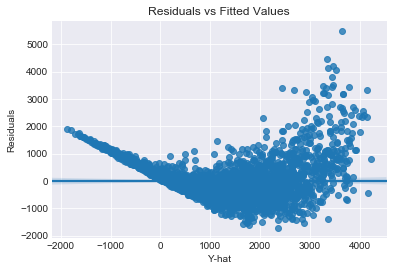

In [19]:
'''Homoskedasticity is when the variance/scatter/spread of the residuals is 
constant for all values of the fitted values. It is an assumption under OLS.

Heteroskedasticity is when the variance of the residuals changes as the fitted values change.
If not addressed, it can lead to biased estimators.
If our residuals were heteroskedastic, we would expect a scatter plot to form a funnel shape,
and a regression line to have a slope.
'''

# Regplot fits a regression line to a scatterplot
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

There is definitely heteroskedasticity present. 

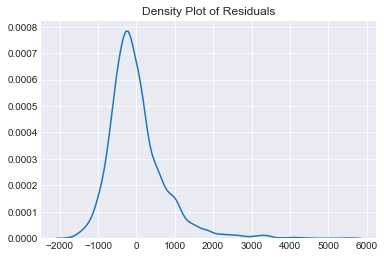

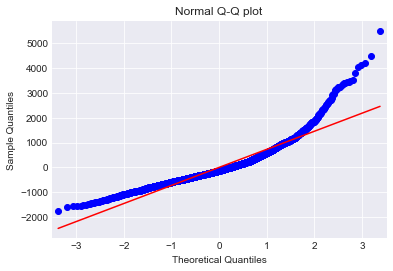

In [20]:
'''Normality of the residuals with mean 0 is another assumption under OLS.
If residuals are nonnormal and not approximately centered at 0, the model is probably misspecified.
The first chart is a kernel density estimation and the second is a Q-Q plot.

Q-Q plots compare two datasets to see whether or not they come from the same distribution.
If they do, the points should form a straight line.
Here, we have a Normal Q-Q plot, where our residuals are being compared against a normal distribution.
'''

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normal?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()

Our residuals are not centered around 0 and not normal.

Work in progress.